In [1]:
# Cache hit-rate distributions
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
%matplotlib inline

In [2]:
# Load persistent data I/O stats of queries
df = pd.read_parquet('~/snowflake-analysis/snowset-main.parquet', columns = ['persistentReadBytesCache', 
                                                                'persistentReadBytesS3', 
                                                                'persistentWriteBytesS3',
                                                               'persistentWriteBytesCache'],
                    engine='fastparquet')

In [5]:
# Calculate total amount of persistent data bytes read and written
df['persistentReadBytes'] = df['persistentReadBytesCache'] + df['persistentReadBytesS3']
# Cache is write-through
df['persistentWriteBytes'] = df['persistentWriteBytesS3']
# Assign query classes
df['ronly'] = (df['persistentWriteBytes'] == 0)
df['wonly'] = (df['persistentReadBytes'] == 0)
df['rw'] = ((df['persistentReadBytes'] > 0) & (df['persistentWriteBytes'] > 0))

In [7]:
# Eliminate W-only queries
df.query('ronly or rw', inplace=True)

In [9]:
# Calculate hitrate
df['hitrate'] = df['persistentReadBytesCache'] / df['persistentReadBytes']

In [20]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def weighted_ecdf(x, w):
    d = pd.DataFrame({'x': x, 'w': w})
    d.sort_values(by='x', inplace=True)
    xs = d['x']
    ys = np.cumsum(d['w']) / np.sum(d['w'])
    return xs,ys


Text(0.5, 1.0, 'R-only queries')

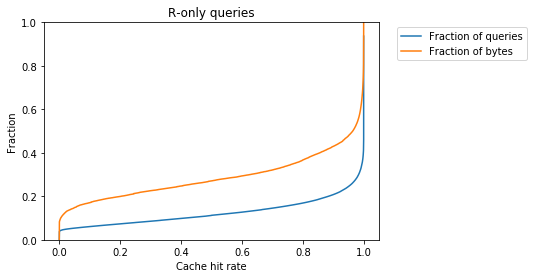

In [23]:
# Plot per-class hit-rate CDFs
plt.plot(*ecdf(df[df['ronly']]['hitrate']), label='Fraction of queries')
plt.plot(*weighted_ecdf(df[df['ronly']]['hitrate'], df[df['ronly']]['persistentReadBytes']), label='Fraction of bytes')
plt.gca().set_ylim((0,1))
plt.gca().legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().set_xlabel('Cache hit rate')
plt.gca().set_ylabel('Fraction')
plt.gca().set_title('R-only queries')

Text(0.5, 1.0, 'RW queries')

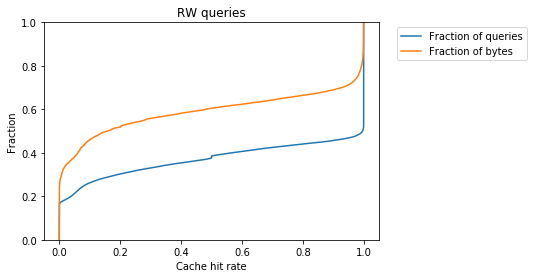

In [24]:
plt.plot(*ecdf(df[df['rw']]['hitrate']), label='Fraction of queries')
plt.plot(*weighted_ecdf(df[df['rw']]['hitrate'], df[df['rw']]['persistentReadBytes']), label='Fraction of bytes')
plt.gca().set_ylim((0,1))
plt.gca().legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().set_xlabel('Cache hit rate')
plt.gca().set_ylabel('Fraction')
plt.gca().set_title('RW queries')